# 0 Summary

For this file, we look at the in-sample data, events from May 2022-June 2023, analyze the returns and volume behaviors around different types of events, and formulate a basic trading strategy.

Our findings suggest that:

    1. For "Add" events, there seems to be a return spike on the day after Announcement, followed by a sharp decline by about 10th day
    
    2. For "Delete" events, MSCI SC, NASDAQ 100, and Russell 2000 seem to have stocks go up after announcement, in about 5 days; SP Completion seems to have no effect; SP 400, 500, and 600 seem to have a negative impact on returns after announcement, for at least 10 days.
    
    3. For "Upweight" events, SP 500 index upweight seems to induce increase in return, while all other indices' "Upweights" experience a decrease in return, duration about 5 days, then an increase for about 10 days.

    4. For "Downweight" events, there seems to be a down movement followed by a up movement. SP600, seeing increase, is notable exception.

    5. For Reclassification events, such as "SP600 to SP500", it seems that in general, all cross-index reclassifications for the SP series led to a decrease in returns, for the next 10 days.

Our basic trading strategy is as follows:

    1. For "Add" events,
        a. For SP500 and SP600, to long for 5 days;
        b. For other indices, to short on the day after announcement, close this position after 5 days.
    
    2. For "Delete" events, 
        a. To short stocks impacted by SP 400, 500, 600 deletion events, and cover the position in 5 day;
        b. To long stocks impacted by MSCI SC, NASDAQ 100, and Russell 2000 in 5 days.
    
    3. For "Upweight" events,
        a. To Long SP 500 after "Upweight" announcement for 5 days;
        b. To Short other indices' "Upweight" announcement for 5 days, cover, then long for 5 days.
    
    4. For "Downweight" events, we take no actions (due to lack of data)
    
    5. For "Reclassification" events, to short, and close the positions after 5 days.

# 1 Analysis

## 0 Analysis of Index + Event compositions

The intuitive theory in mind is that the announcements and trading events would generate liquidity events from index funds and speculators, but such events would dissipate, leading to a return to usual price levels.

Our hypothesis from this model is that we would see a return spike(drop) for events "Add" and "Upweight" ("Delete" and "Downweight"), as well as e.g. "SP400 to SP500" ("SP500 to SP400"), followed by a negative(positive) return shortly after.

We first look at the number of occurrences for each types of events for each index.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Looking at events and indices:
file_path = 'D:\GitHub\Equity Project\B Separating Files for Backtest\Index_Event_Data_Before_June_2023.csv'
index_event_data = pd.read_csv(file_path)

# Extract and sort the list of unique indices and actions
indices = sorted(index_event_data['Index Change'].unique())
cleaned_actions = sorted(index_event_data['Action'].unique())

# Create a two-way table (pivot table)
two_way_table = pd.pivot_table(index_event_data, values='Ticker', index='Index Change', columns='Action', aggfunc='count', fill_value=0)

two_way_table.loc['Total',:]= two_way_table.sum(axis=0)
two_way_table.loc[:,'Total'] = two_way_table.sum(axis=1)

# Display the two-way table
print("\nTwo-way table showing the count of entries for each action and index:")
two_way_table


Two-way table showing the count of entries for each action and index:


Action,Add,Delete,Downweight,MSCI SC to Std,SP400 to SP500,SP400 to SP600,SP500 to SP400,SP500 to SP600,SP600 to SP400,Upweight,Total
Index Change,,,,,,,,,,,
MSCI SC,8.0,83.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,120.0,214.0
MSCI Std,2.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,26.0
Nasdaq 100,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
Russell 1000,11.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,60.0
Russell 2000,16.0,68.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,125.0
Russell 3000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
S&P Completion,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
S&P Total Market,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
SP400,36.0,20.0,1.0,0.0,3.0,8.0,4.0,0.0,9.0,16.0,97.0


It should be noted that there are many cells with very few entries. Especially under action "Downweight," there are only 13 events in total. This may make data extrapolation difficult.

Below we calculate the percentage returns for each entry, normalized with SPY return of the same day:

We also look at the average gaps and standard deviations between announcements and trading, grouped by actions and indices:

In [109]:
# Convert date columns to datetime
index_event_data['Announced'] = pd.to_datetime(index_event_data['Announced'])
index_event_data['Trade Date'] = pd.to_datetime(index_event_data['Trade Date'])

# Calculate the gap between announcement and trade date
index_event_data['Gap'] = (index_event_data['Trade Date'] - index_event_data['Announced']).dt.days

# Calculate the mean and standard error for the gap between announcement and trade date, grouped by index and action
gap_stats = index_event_data.groupby(['Index Change', 'Action'])['Gap'].agg(['mean', 'sem']).reset_index()

# Merge the mean and standard error into a single string column
gap_stats['Gap (Mean ± SE)'] = gap_stats.apply(lambda row: f"{row['mean']:.2f} ({row['sem']:.2f})", axis=1)

# Create a pivot table with 'Index Change' as rows and 'Action' as columns
pivot_table_with_se = gap_stats.pivot(index='Index Change', columns='Action', values='Gap (Mean ± SE)')

pivot_table_with_se

Action,Add,Delete,Downweight,MSCI SC to Std,SP400 to SP500,SP400 to SP600,SP500 to SP400,SP500 to SP600,SP600 to SP400,Upweight
Index Change,,,,,,,,,,
MSCI SC,4.62 (0.42),2.99 (0.13),2.00 (0.00),2.00 (nan),NaN,NaN,NaN,NaN,NaN,3.03 (0.11)
MSCI Std,5.50 (0.50),2.56 (0.38),3.00 (nan),2.00 (nan),NaN,NaN,NaN,NaN,NaN,2.46 (0.27)
Nasdaq 100,7.00 (0.00),7.00 (0.00),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Russell 1000,4.45 (1.02),4.20 (0.34),3.00 (1.00),NaN,NaN,NaN,NaN,NaN,NaN,3.12 (0.24)
Russell 2000,8.69 (1.65),3.53 (0.21),4.00 (nan),NaN,NaN,NaN,NaN,NaN,NaN,3.62 (0.36)
Russell 3000,14.00 (nan),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S&P Completion,7.00 (nan),2.33 (0.42),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S&P Total Market,NaN,2.33 (0.33),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP400,7.06 (0.65),5.10 (0.33),5.00 (nan),NaN,3.67 (1.67),4.12 (0.72),10.25 (1.44),NaN,5.11 (0.59),4.25 (1.00)


In [123]:
# Load the price data
price_data = pd.read_csv('D:\GitHub\Equity Project\B Separating Files for Backtest\Price_data_Before_June_2023.csv')

# Convert the 'Date' column to datetime format
price_data['Date'] = pd.to_datetime(price_data['Date']).dt.strftime('%Y-%m-%d')

# Sort the data by Ticker and Date
price_data = price_data.sort_values(by=['Ticker', 'Index', 'Shares Traded', 'Date'])

# Calculate the daily returns and normalize with market return.
# Note that I use 'Shares Traded' as part of event id, since it seems relatively unique to each event
price_data['Return'] = price_data.groupby(['Ticker', 'Index', 'Shares Traded'])['Close'].pct_change()
# Load SPY data with returns
spy_data_file_path = 'D:\GitHub\Equity Project\AA SPDR_ETF_Data\SPY_data.csv'
spy_data = pd.read_csv(spy_data_file_path)
spy_data['Date'] = pd.to_datetime(spy_data['Date'], utc=True).dt.tz_localize(None).dt.strftime('%Y-%m-%d')

# Merge price_data with SPY data on 'Date'
price_data = price_data.merge(spy_data[['Date', 'Return']], on='Date', suffixes=('', '_SPY'))

# Calculate the return difference
price_data['Normalized Return'] = price_data['Return'] - price_data['Return_SPY']

price_data['Cumulative Normalized Return'] = price_data.groupby(['Ticker', 'Index', 'Shares Traded'])['Normalized Return'].cumsum()

price_data['Volume Change'] = price_data.groupby(['Ticker', 'Index', 'Shares Traded'])['Volume'].pct_change()

# Drop the first entry of each group (where 'Return' is NaN)
price_data = price_data.dropna(subset=['Return', 'Volume Change', 'Cumulative Normalized Return'])

# Display the first few rows of the dataframe with the new 'Return' column
#price_data.head()


Since different kinds of actions have different dynamics and impacts on the price, ensuing analysis would be by actions.

## 1 Return Behaviors around "Add" Events

Here we plot the volume changes and returns around announcements, for the event type "Add", color coded by indices. 

Note that I often use scatter plots, instead of line plots by tickers, for graph readability and computational load

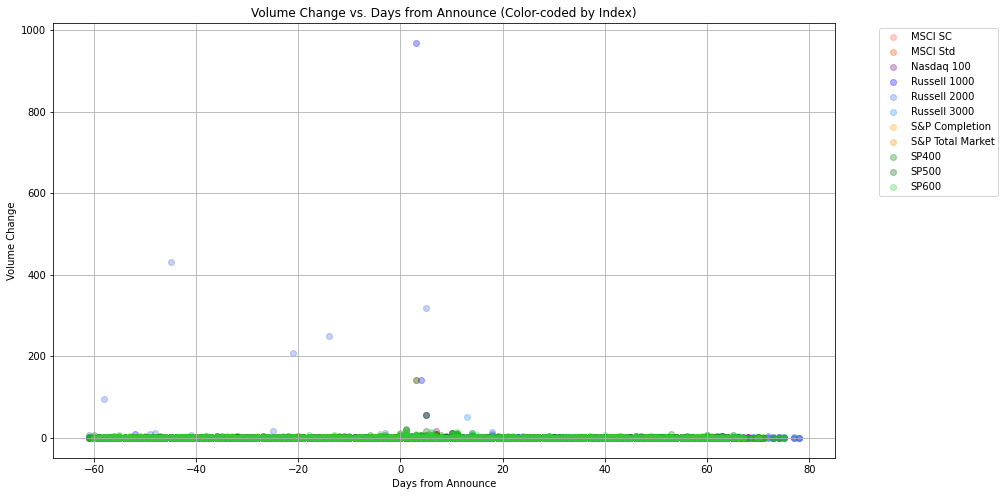

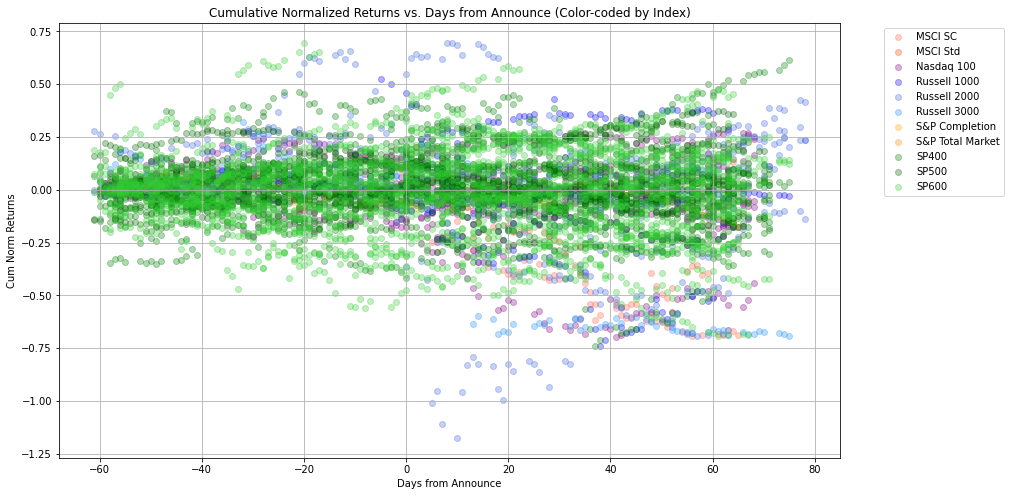

<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

In [82]:
data_add_only = price_data[price_data['Action'] == 'Add']
# Define colors for each indices
# Define colors for each index
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot the volume, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_add_only[data_add_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Volume Change'], alpha=0.3, label=index, color=color)

plt.title('Volume Change vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Volume Change')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the Returns, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_add_only[data_add_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Cumulative Normalized Return'], alpha=0.3, label=index, color=color)
plt.title('Cumulative Normalized Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Cum Norm Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot Returns for each ticker over time
plt.figure(figsize=(14, 8))

# # Group by Ticker and plot each one
# for ticker, group_data in data_add_only.groupby('Ticker'):
#     plt.plot(group_data['Days from Announce'], group_data['Return'], label=ticker)

# plt.title('Return Over Time for Each Ticker')
# plt.xlabel('Days from Announce')
# plt.ylabel('Return')
# #plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.show()

# #Plot the Average return, grouped by Index
# average_returns_add_only = data_add_only.groupby(['Index','Days from Announce'])['Return'].mean().reset_index()
# # Plot the average returns
# plt.figure(figsize=(14, 8))
# for index, color in index_colors.items():
#     subset = average_returns[average_returns['Index'] == index]
#     plt.plot(subset['Days from Announce'], subset['Return'], alpha=0.7, label=index, color=color)
# plt.title('Average Returns vs. Days from Announce, grouped by Index')
# plt.xlabel('Days from Announce')
# plt.ylabel('Ave. Return')
# plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


Below we look at the cumulative average normalized return behaviors for each indices seperately:

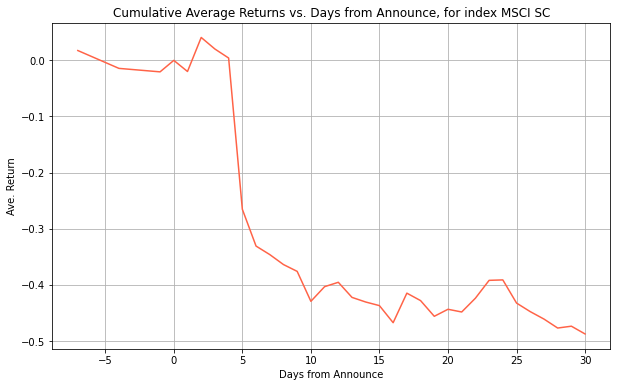

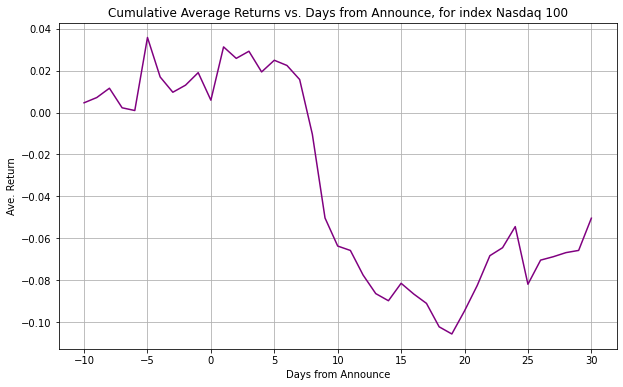

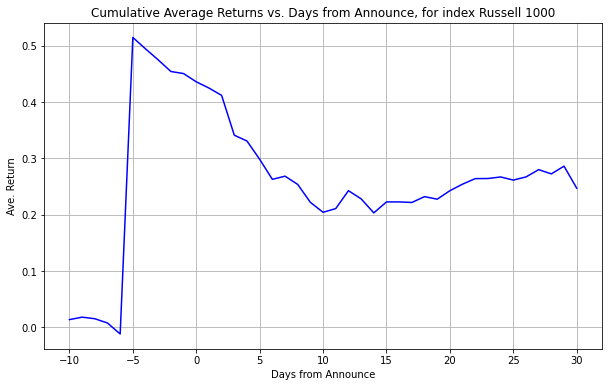

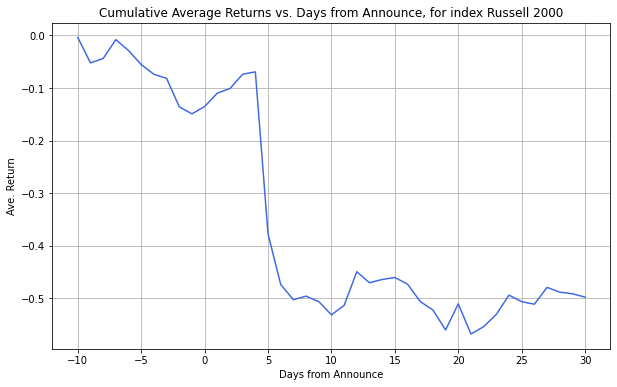

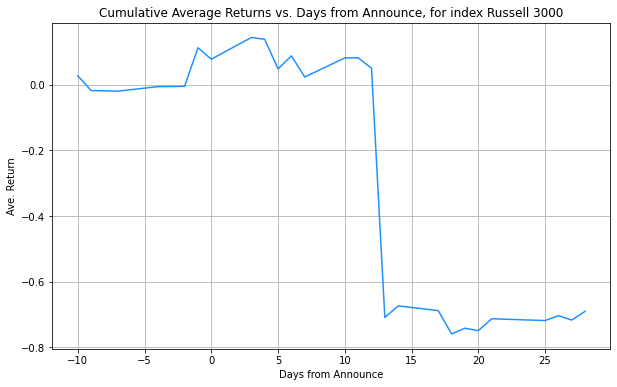

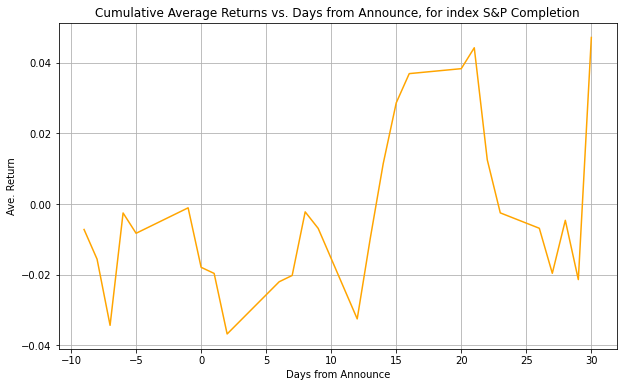

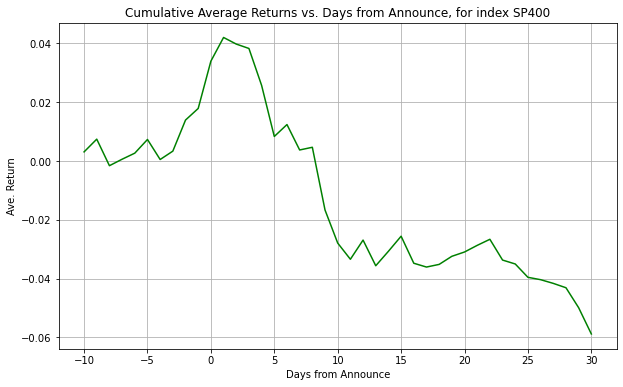

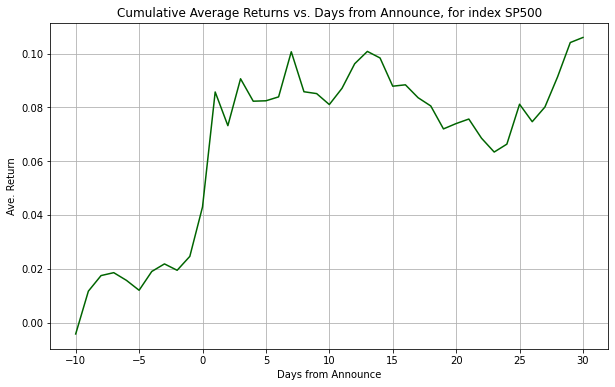

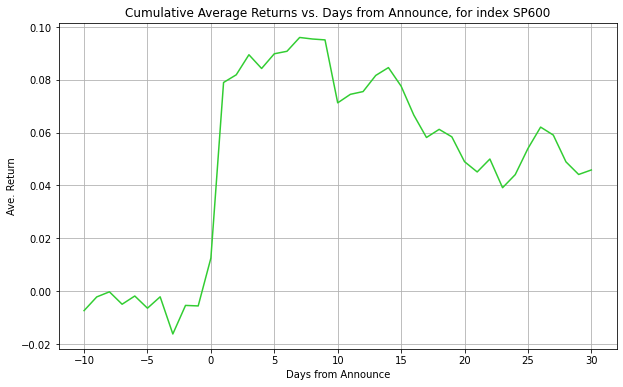

In [122]:
#Plot the Average return, grouped by Index
average_returns_add_only = data_add_only.groupby(['Index','Days from Announce'])['Normalized Return'].mean().reset_index()
indices_add = sorted(data_add_only['Index'].unique())

# Plot the average returns
for index in indices_add:
    plt.figure(figsize=(10, 6))
    subset = average_returns_add_only[average_returns_add_only['Index'] == index]
    subset = subset[(subset['Days from Announce']<31) & (subset['Days from Announce']>-11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Announce'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Cumulative Average Returns vs. Days from Announce, for index ' + index)
    plt.xlabel('Days from Announce')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

(We hightlight that since SP Completion, Russell 3000, and MSCI Std have 1 or 2 "Add" events, we will not draw much inference for those indices specifically.)

In general, there seems to be a return spike on the day after Announcement, followed by a sharp decline by about 10th day, supporting the mean reversion hypothesis

Noteworthy exception are SP500 and SP600, which see an uptick by day 10.

Here we plot the Return changes against "Days from Trade":

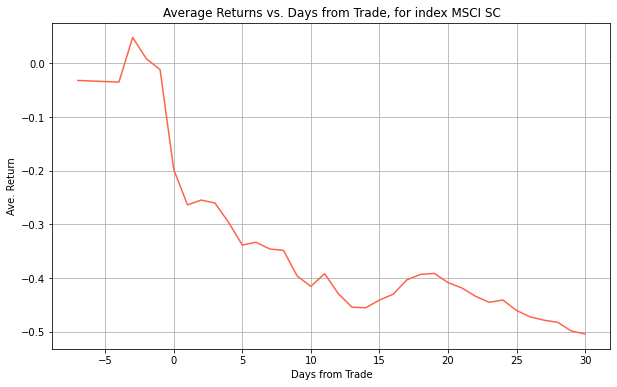

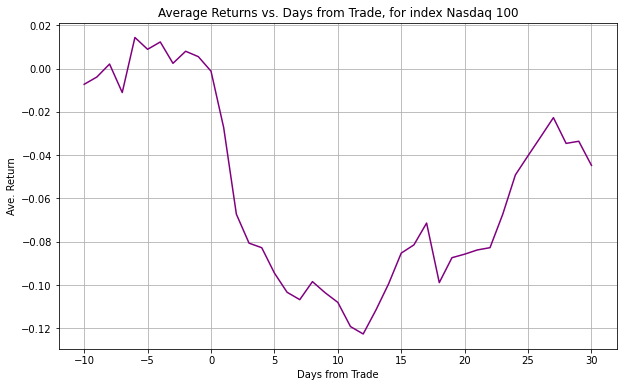

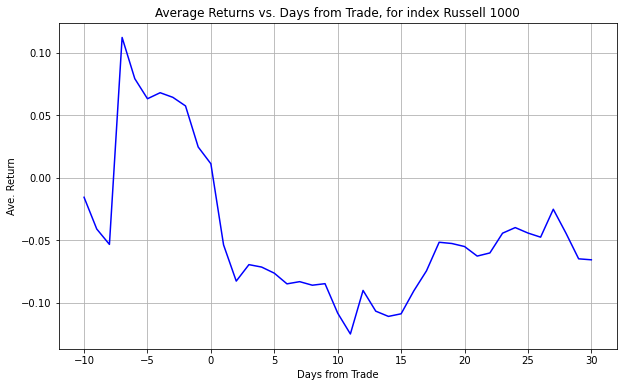

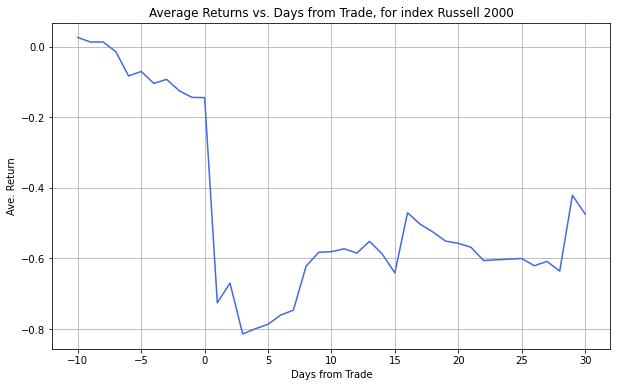

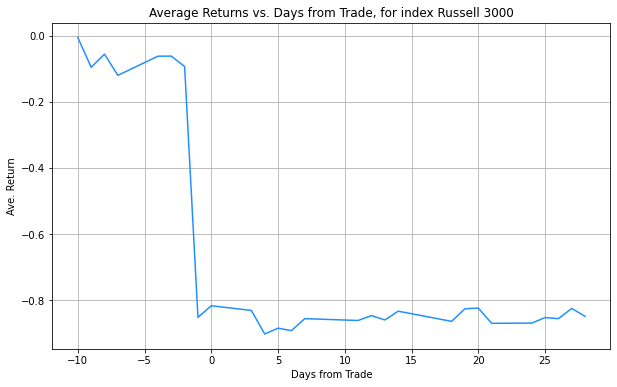

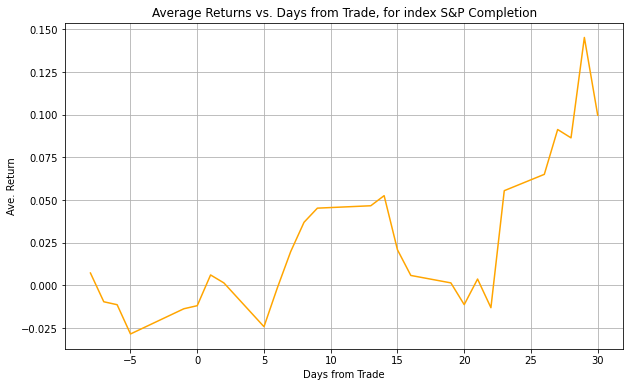

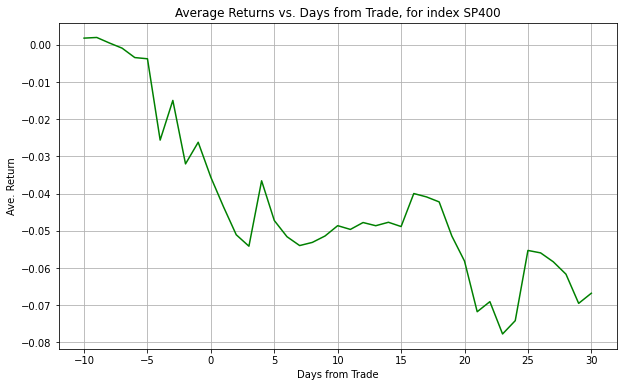

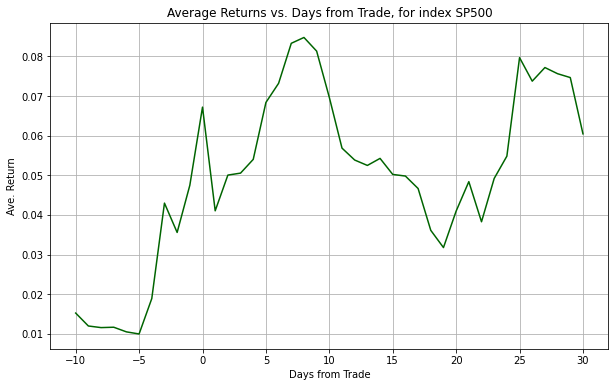

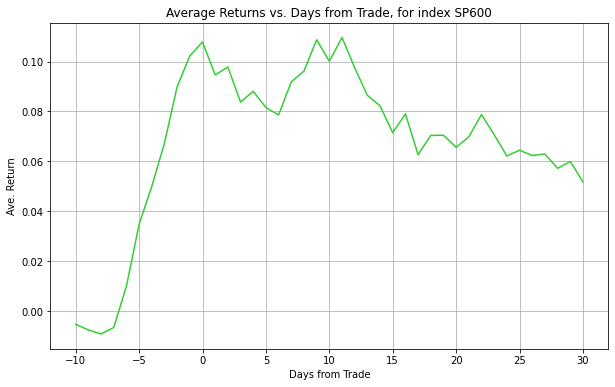

In [84]:
average_returns_add_only = data_add_only.groupby(['Index','Days from Trade'])['Normalized Return'].mean().reset_index()

for index in indices_add:
    plt.figure(figsize=(10, 6))
    subset = average_returns_add_only[average_returns_add_only['Index'] == index]
    subset = subset[(subset['Days from Trade']<31) & (subset['Days from Trade']>-11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Trade'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Average Returns vs. Days from Trade, for index ' + index)
    plt.xlabel('Days from Trade')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

On the other hand, it seems that by the time of actual index rebalance, there is a drop in return in the following 10 days. This could be exlained as overlapping from announcements, and suggest that the announcements may have a bigger price impact than the index tradings themselves. 

So our tentative trading strategy around "Add" event is: 

    1. For SP500 and SP600, to long for 5 days;
    2. For other indices, to short on the day after announcement, close this position after 5 days.

## 2 Return Behaviors around "Delete" Events

Now we move onto the "Deletion Events". It should be noted that there are many more "Delete" events in the in-sample period than other types.

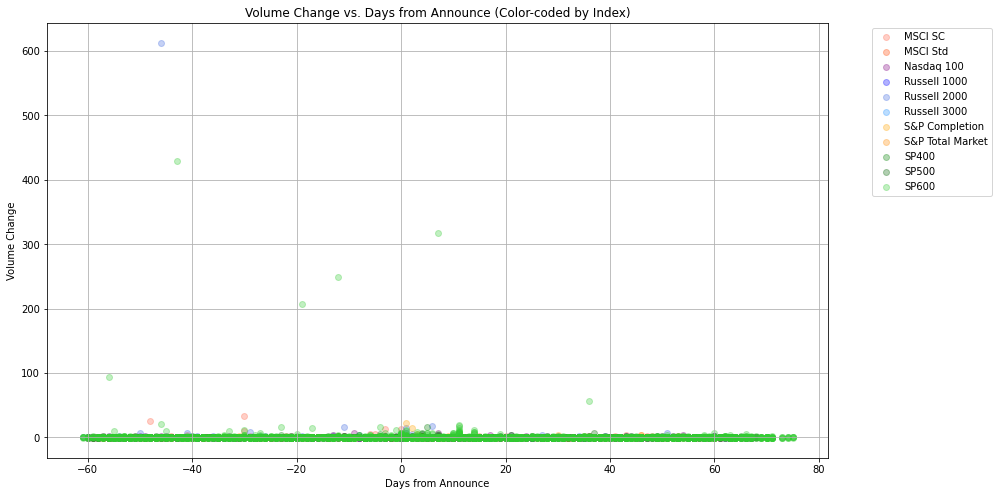

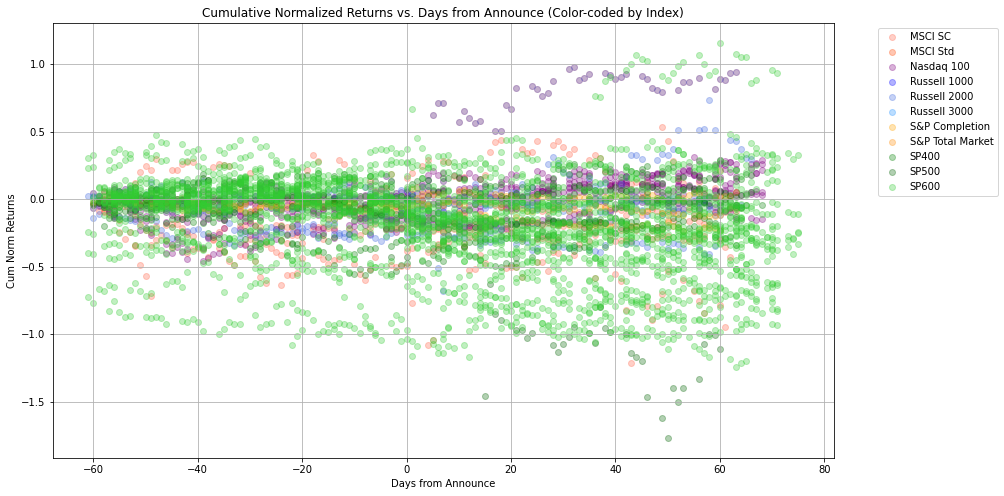

<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

In [85]:
# Filter data for 'Delete' events
data_delete_only = price_data[price_data['Action'] == 'Delete']

# Define colors for each index
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot the volume, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_delete_only[data_delete_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Volume Change'], alpha=0.3, label=index, color=color)

plt.title('Volume Change vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Volume Change')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the Returns, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_delete_only[data_delete_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Cumulative Normalized Return'], alpha=0.25, label=index, color=color)
plt.title('Cumulative Normalized Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Cum Norm Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot Returns for each ticker over time
plt.figure(figsize=(14, 8))

Below is the graph for Cumulative mean returns by each index:

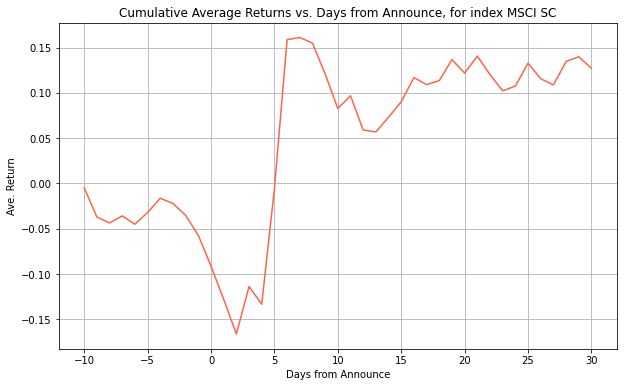

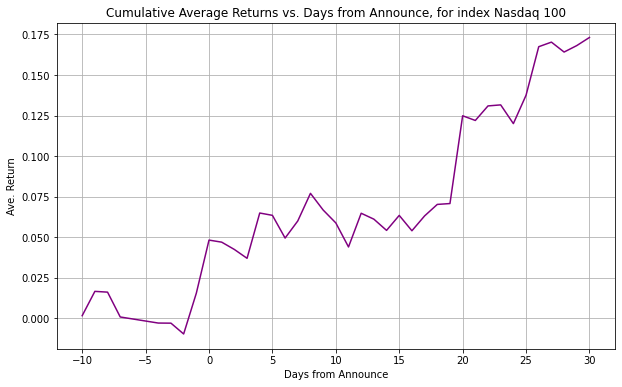

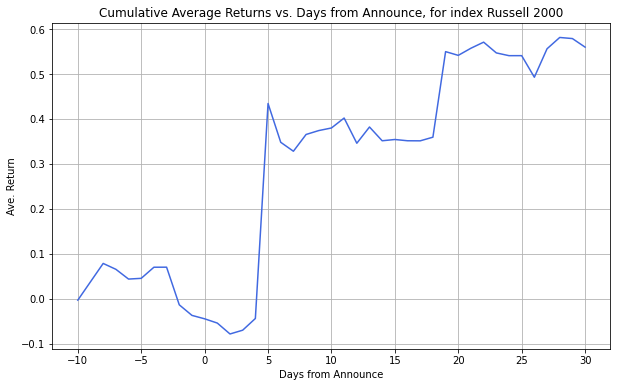

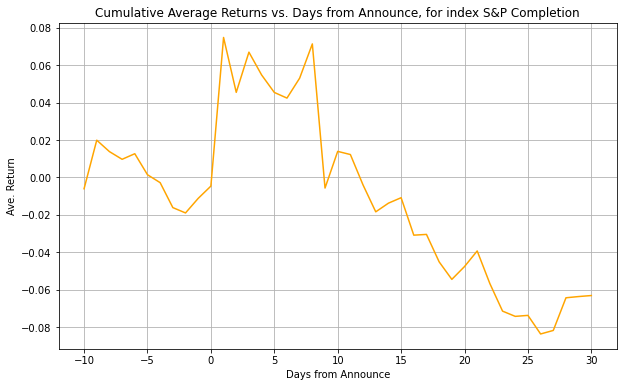

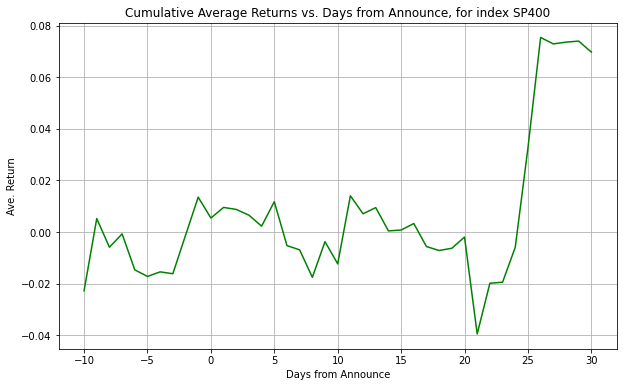

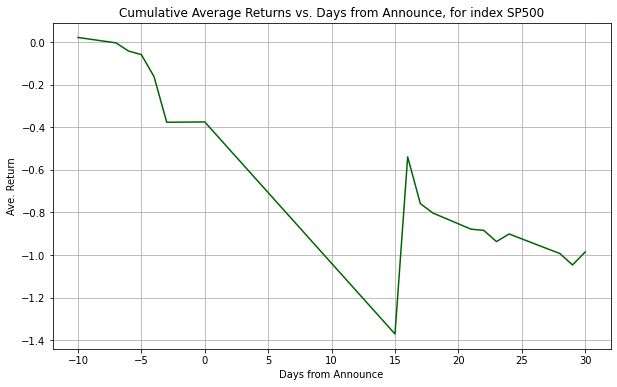

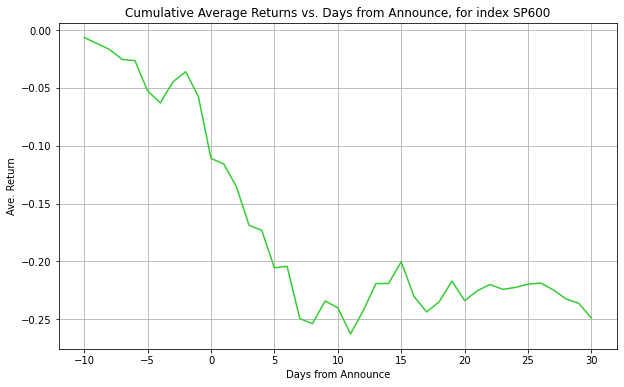

In [86]:
# Plot the Average return, grouped by Index
average_returns_delete_only = data_delete_only.groupby(['Index', 'Days from Announce'])['Normalized Return'].mean().reset_index()
indices_delete = sorted(data_delete_only['Index'].unique())

# Plot the average returns
for index in indices_delete:
    plt.figure(figsize=(10, 6))
    subset = average_returns_delete_only[average_returns_delete_only['Index'] == index]
    subset = subset[(subset['Days from Announce'] < 31) & (subset['Days from Announce'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Announce'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Cumulative Average Returns vs. Days from Announce, for index ' + index)
    plt.xlabel('Days from Announce')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

Interestingly, different indices seem to have different effects on stock returns when announcing "Delete".

MSCI SC, NASDAQ 100, and Russell 2000 seem to have stocks go up after announcement, in about 5 days;
SP Completion seems to have no effect;
SP 400, 500, and 600 seem to have a negative impact on returns after announcement, for at least 10 days.

It should be noted that SP Completion only has 6 instances of deletion in the in-sample period, unlikely to be informative.

We show the stock returns around Trade days as well:

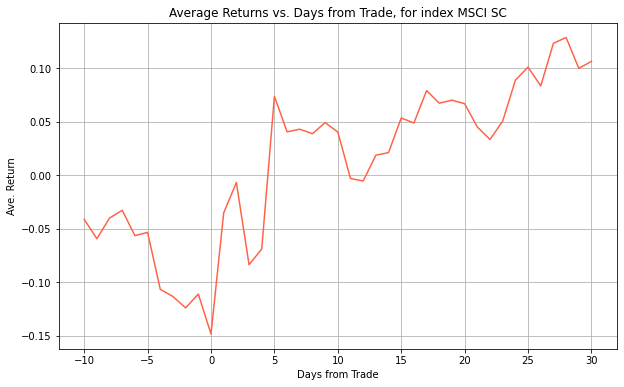

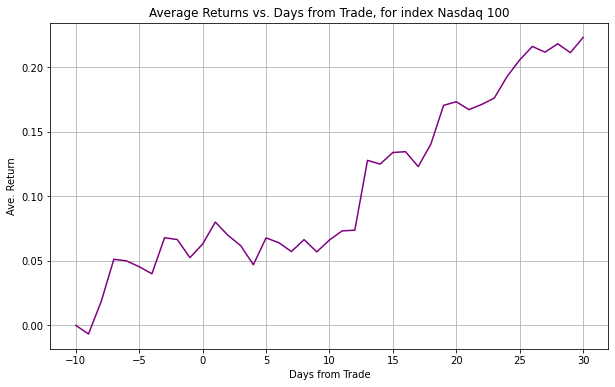

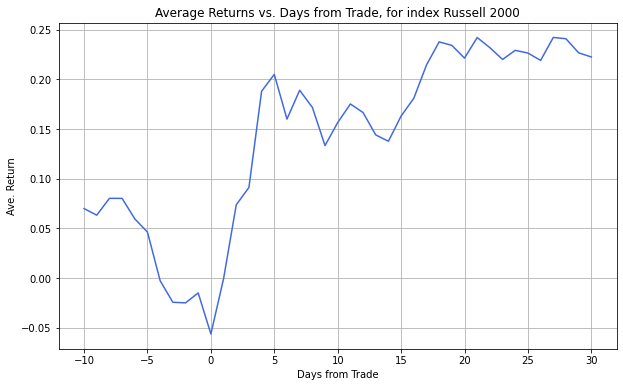

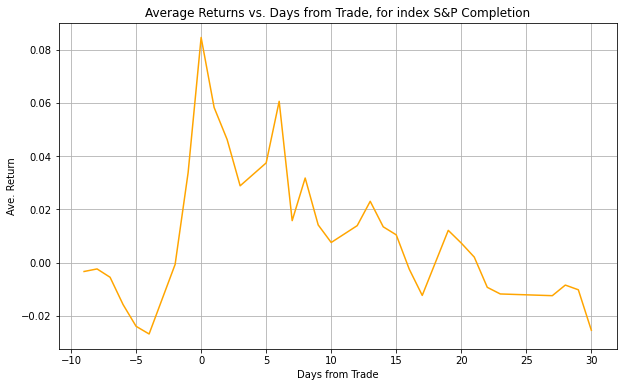

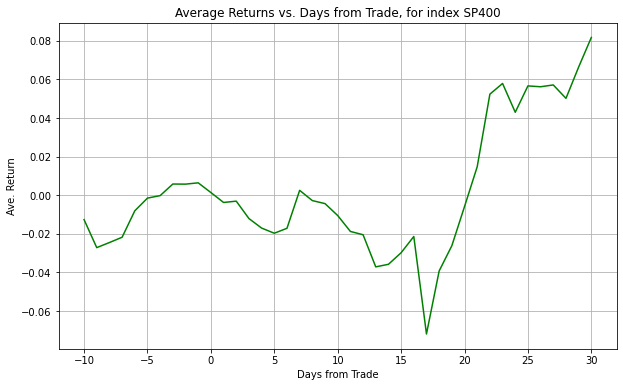

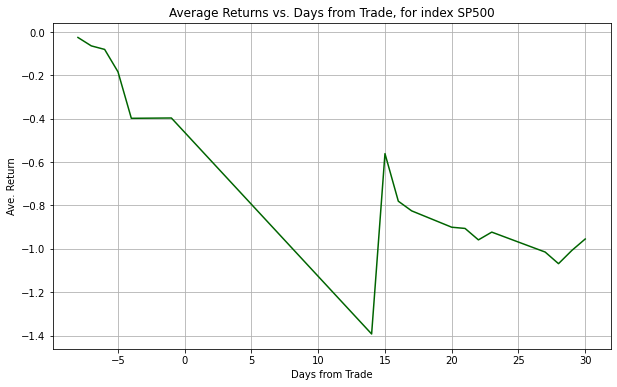

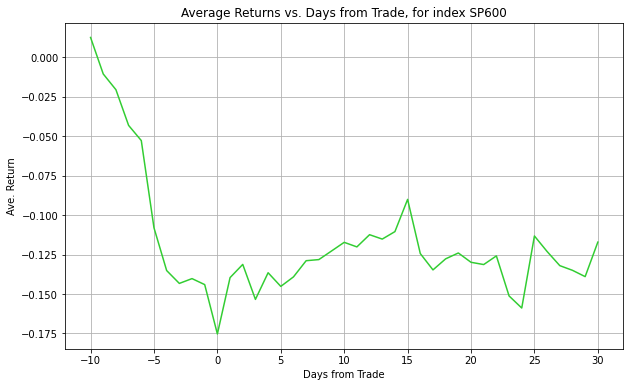

In [87]:
# Plot the Average return, grouped by Index
average_returns_delete_only = data_delete_only.groupby(['Index', 'Days from Trade'])['Normalized Return'].mean().reset_index()
indices_delete = sorted(data_delete_only['Index'].unique())

# Plot the average returns
for index in indices_delete:
    plt.figure(figsize=(10, 6))
    subset = average_returns_delete_only[average_returns_delete_only['Index'] == index]
    subset = subset[(subset['Days from Trade'] < 31) & (subset['Days from Trade'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Trade'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Average Returns vs. Days from Trade, for index ' + index)
    plt.xlabel('Days from Trade')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

We again note that the patterns do not change much, as announcements and trading is usually lagged by a week only.

Our tentative trading strategy plan would be: 

    1. To short stocks impacted by SP 400, 500, 600 deletion events, and cover the position in 5 day;
    2. To long stocks impacted by MSCI SC, NASDAQ 100, and Russell 2000 in 5 days.

With this, we move to the "Upweight" events.

## 3 Return Behaviors around "Upweight" events

We first note that "Upweight" also is very frequent in the in-sample period, with MSCI SC notabily taking up nearly half (120/241) of the instances, while the SP series upweights less frequently.

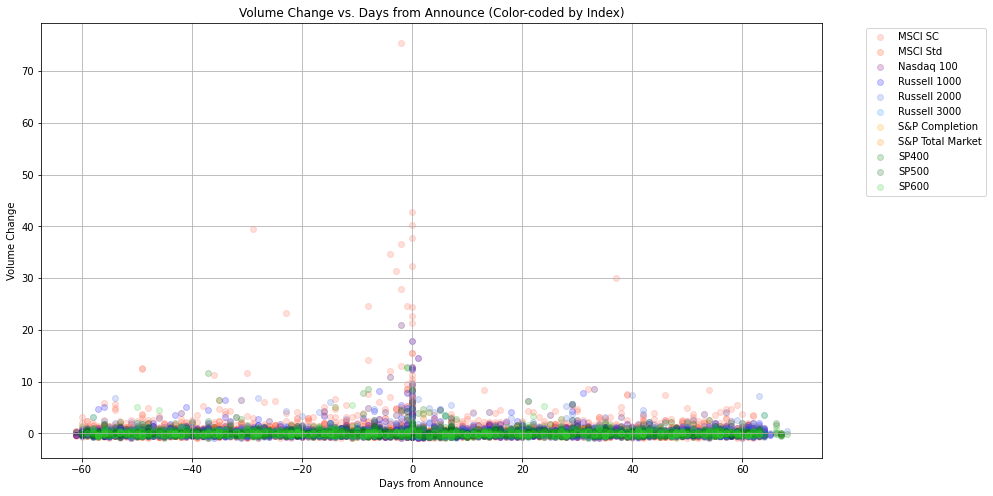

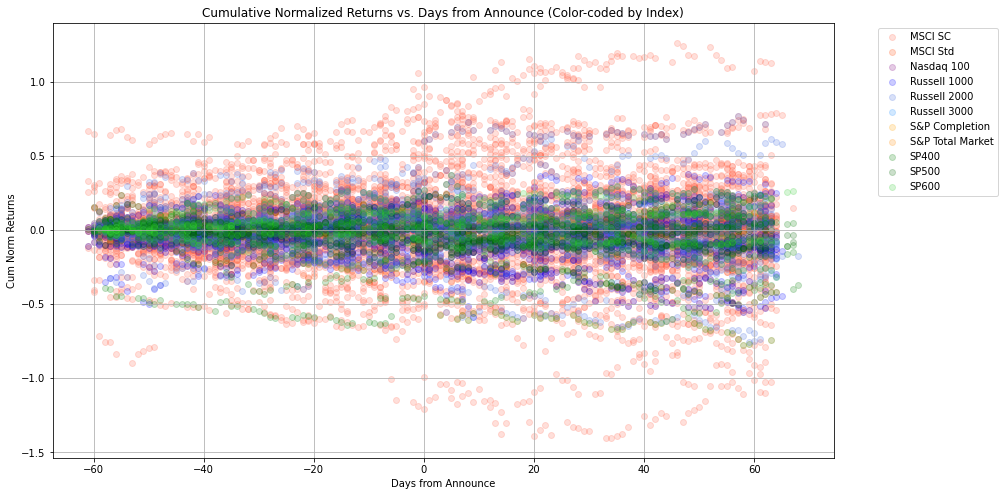

In [94]:
# Filter data for 'Upweight' events
data_upweight_only = price_data[price_data['Action'] == 'Upweight']

# Define colors for each index
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot the volume, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_upweight_only[data_upweight_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Volume Change'], alpha=0.2, label=index, color=color)

plt.title('Volume Change vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Volume Change')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the Returns, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_upweight_only[data_upweight_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Cumulative Normalized Return'], alpha=0.2, label=index, color=color)
plt.title('Cumulative Normalized Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Cum Norm Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


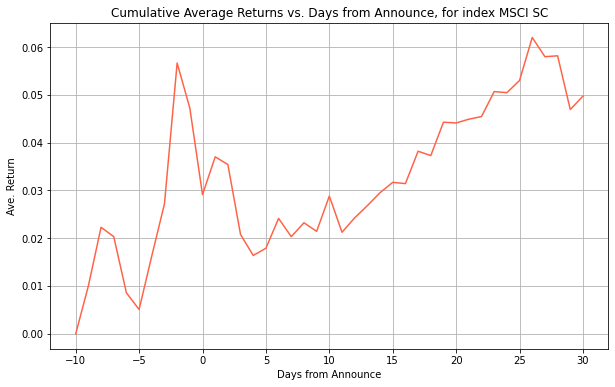

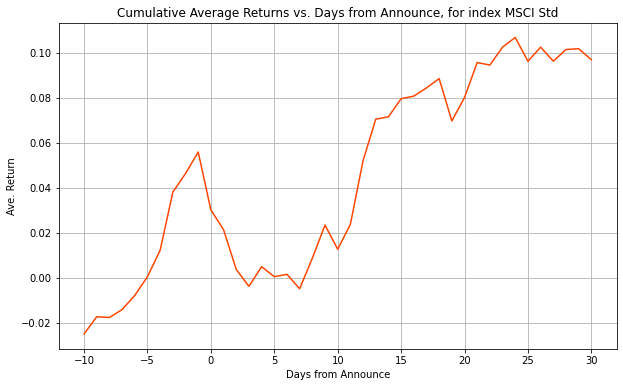

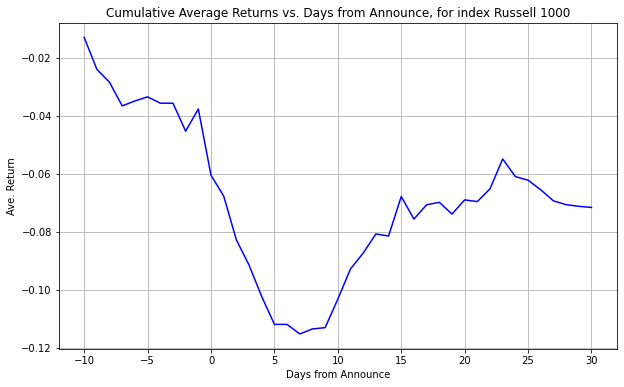

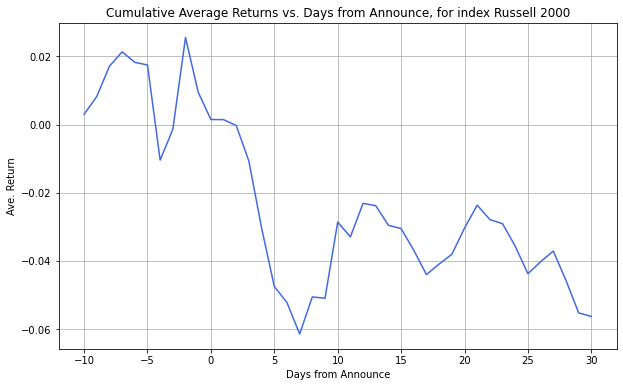

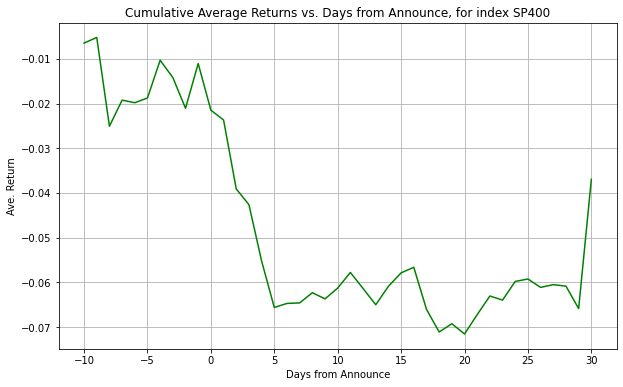

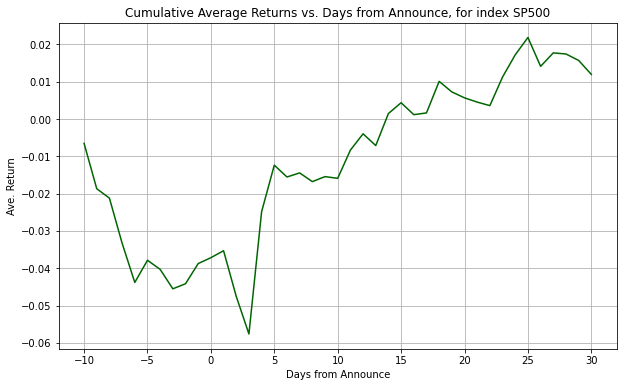

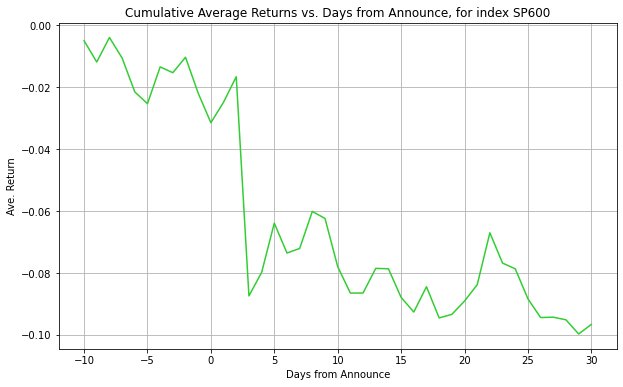

In [89]:
# Plot the Average return, grouped by Index
average_returns_upweight_only = data_upweight_only.groupby(['Index', 'Days from Announce'])['Normalized Return'].mean().reset_index()
indices_upweight = sorted(data_upweight_only['Index'].unique())

# Plot the average returns
for index in indices_upweight:
    plt.figure(figsize=(10, 6))
    subset = average_returns_upweight_only[average_returns_upweight_only['Index'] == index]
    subset = subset[(subset['Days from Announce'] < 31) & (subset['Days from Announce'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Announce'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Cumulative Average Returns vs. Days from Announce, for index ' + index)
    plt.xlabel('Days from Announce')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

Notably, SP 500 index upweight seems to induce increase in return, while all other indices' "Upweights" experience a decrease in return, duration about 5 days, then an increase for about 10 days. Agains, we note the relative paucity of SP series "Upweight" events

Here is the Cumulative mean returns mapped against Days from Trade:

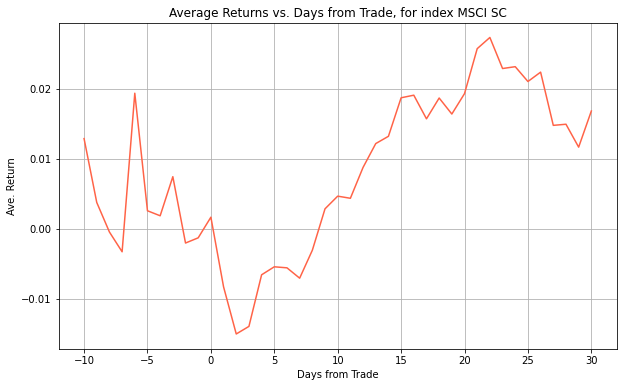

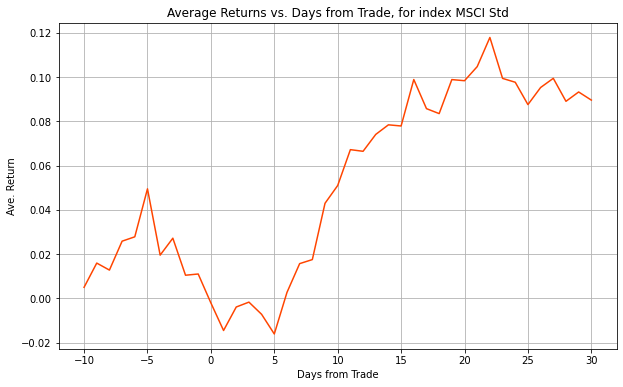

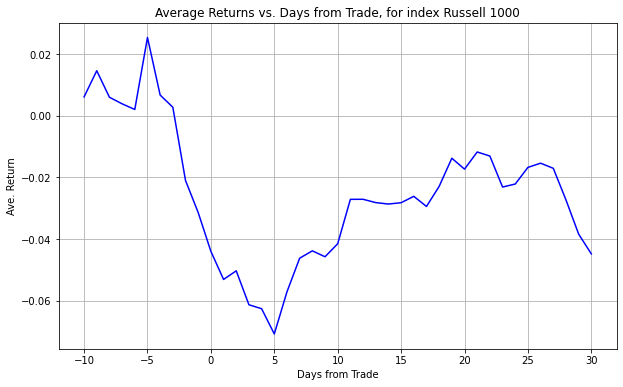

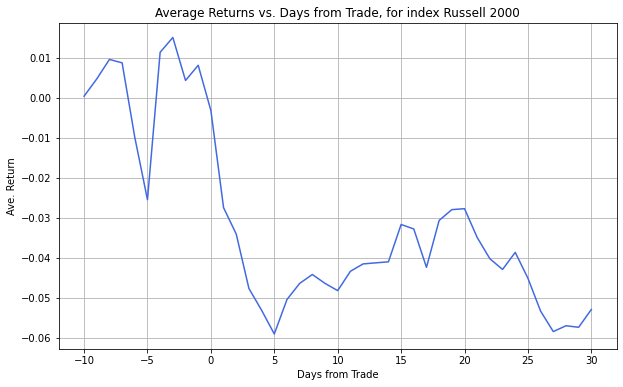

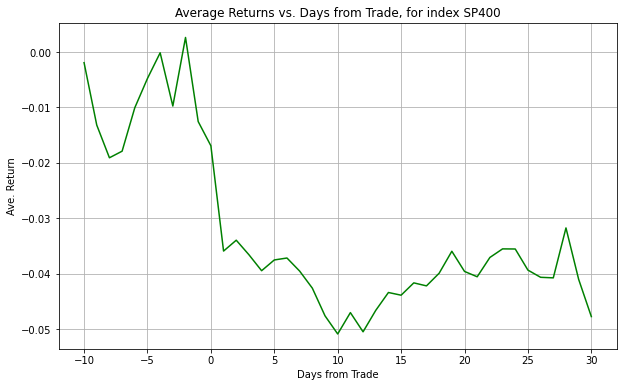

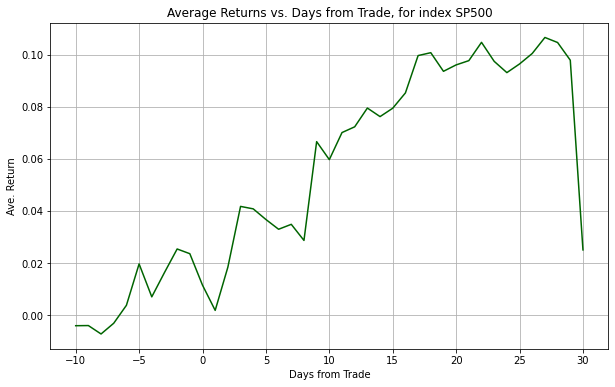

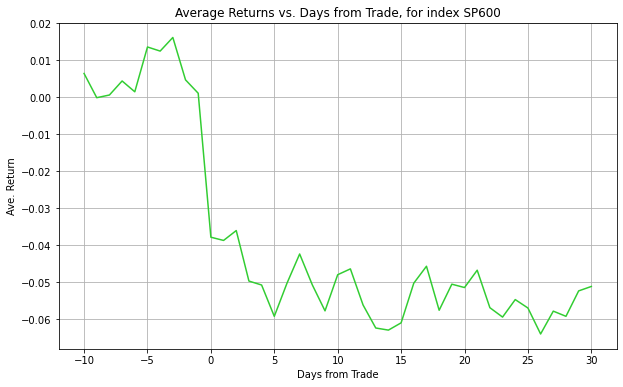

In [90]:
# Plot the Average return, grouped by Index
average_returns_upweight_only = data_upweight_only.groupby(['Index', 'Days from Trade'])['Normalized Return'].mean().reset_index()
indices_upweight = sorted(data_upweight_only['Index'].unique())

# Plot the average returns
for index in indices_upweight:
    plt.figure(figsize=(10, 6))
    subset = average_returns_upweight_only[average_returns_upweight_only['Index'] == index]
    subset = subset[(subset['Days from Trade'] < 31) & (subset['Days from Trade'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Trade'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Average Returns vs. Days from Trade, for index ' + index)
    plt.xlabel('Days from Trade')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()


Again, similar patterns due to trading days' 7 day lag.

Our tentative strategy then is:

    1. To Long SP 500 after "Upweight" announcement for 15 days;
    2. To Short other indices' "Upweight" announcement for 5 days, cover, then long for 5 days.

With this, we now look at "Downweight":

## 4 Return Behaviors around "Downweight" Events

In sharp contrast with "Upweight" events, there are only very few instances of "Downweight" events. This may make our inference very weak. We should be cautious to take any position using this data.

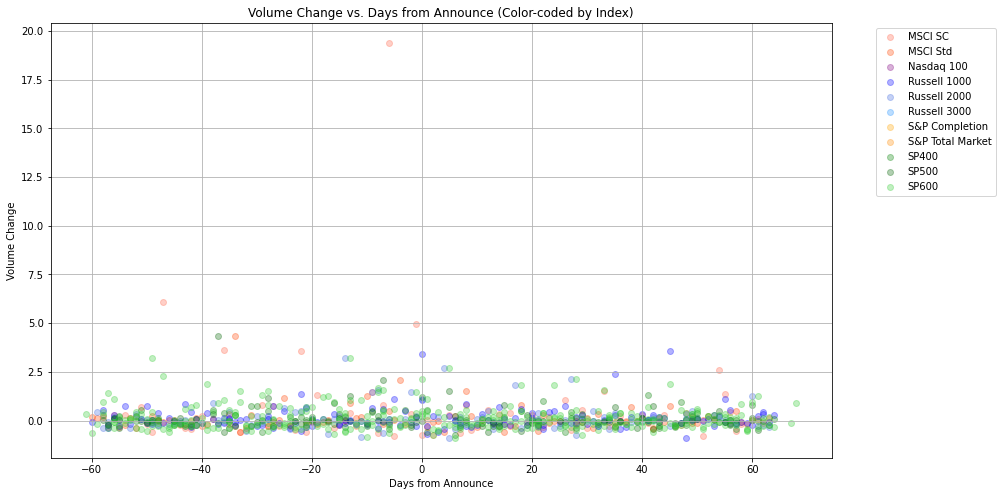

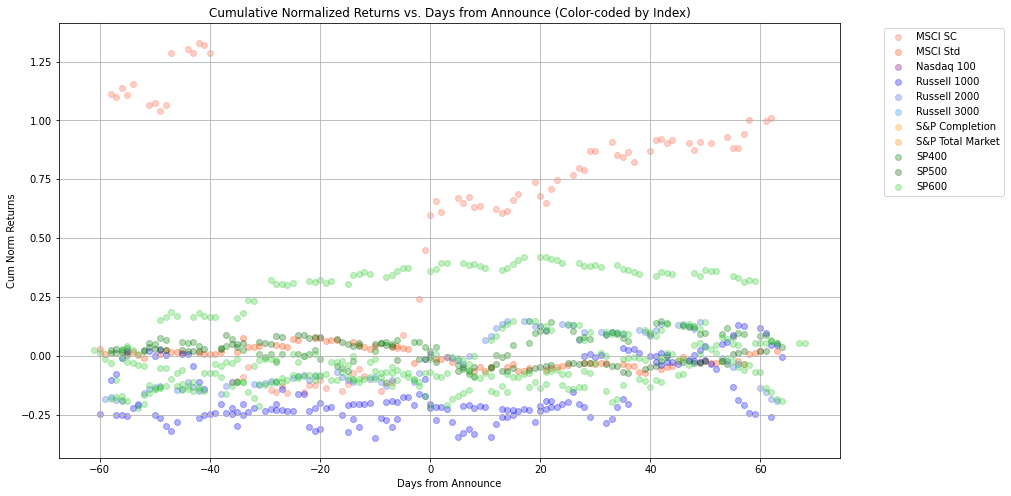

<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

In [92]:
# Filter data for 'Downweight' events
data_downweight_only = price_data[price_data['Action'] == 'Downweight']

# Define colors for each index
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot the volume, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_downweight_only[data_downweight_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Volume Change'], alpha=0.3, label=index, color=color)

plt.title('Volume Change vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Volume Change')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the Returns, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_downweight_only[data_downweight_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Cumulative Normalized Return'], alpha=0.3, label=index, color=color)
plt.title('Cumulative Normalized Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Cum Norm Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



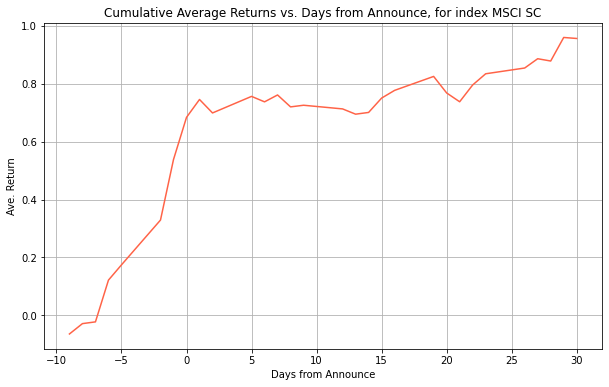

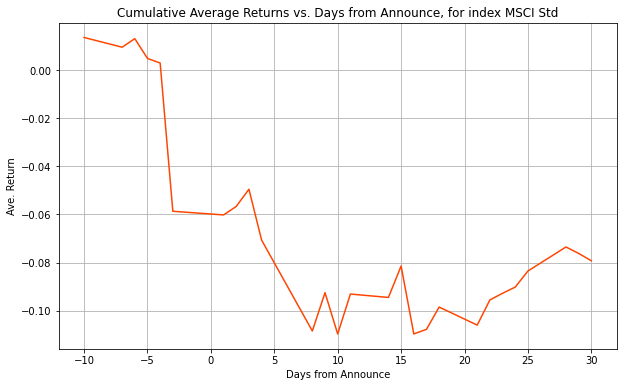

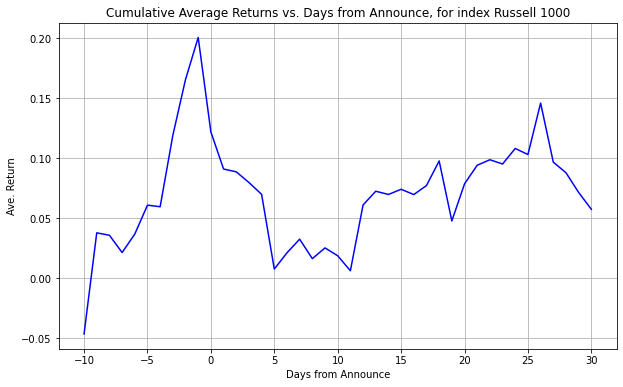

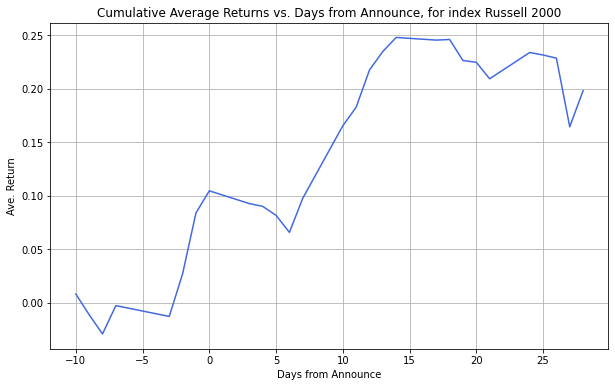

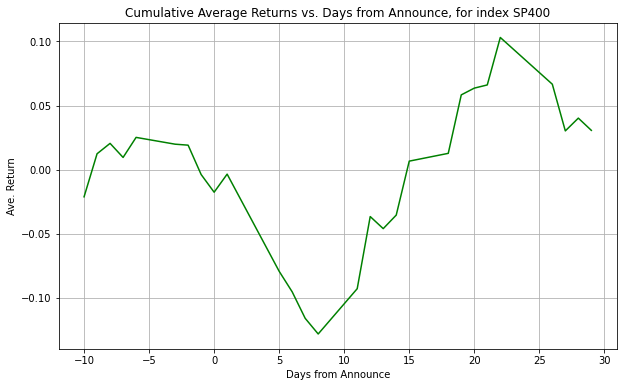

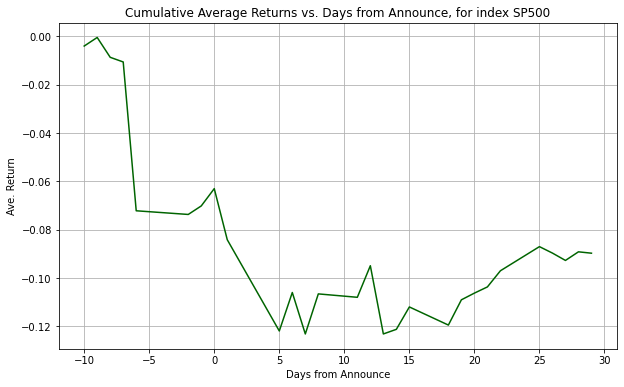

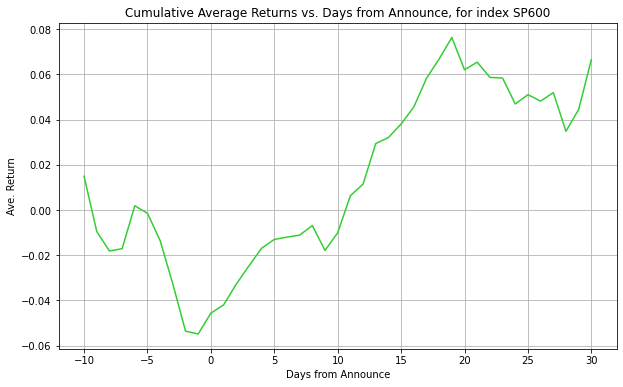

In [95]:
# Plot the Average return, grouped by Index
average_returns_downweight_only = data_downweight_only.groupby(['Index', 'Days from Announce'])['Normalized Return'].mean().reset_index()
indices_downweight = sorted(data_downweight_only['Index'].unique())

# Plot the average returns
for index in indices_downweight:
    plt.figure(figsize=(10, 6))
    subset = average_returns_downweight_only[average_returns_downweight_only['Index'] == index]
    subset = subset[(subset['Days from Announce'] < 31) & (subset['Days from Announce'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Announce'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Cumulative Average Returns vs. Days from Announce, for index ' + index)
    plt.xlabel('Days from Announce')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()


It seems that "Downweight" events feature similar dynamic to "Upweight" events, a down movement followed by a up movement. SP600, seeing increase, is notable exception.

It once again should be stressed that there are fewer than 5 instances of "Downweight" for most indices, with SP600 only having 5.

We check the graph against trading timeline for completion:

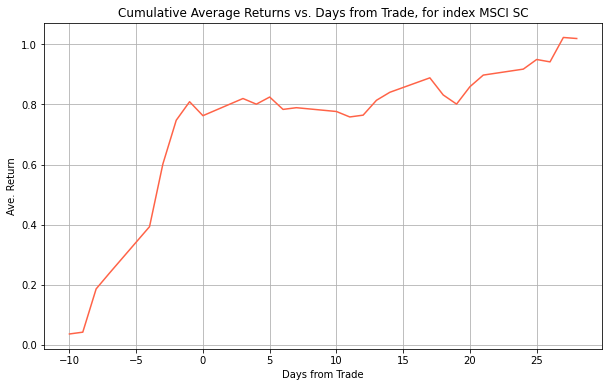

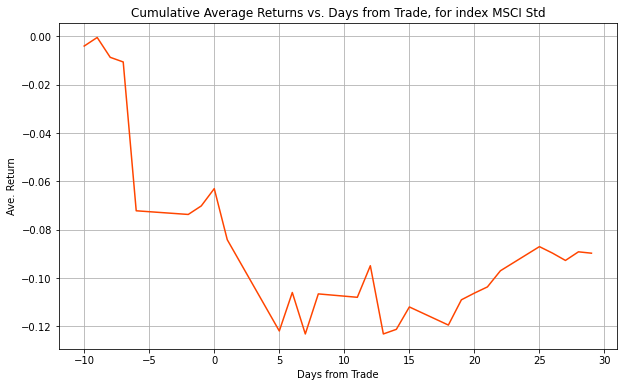

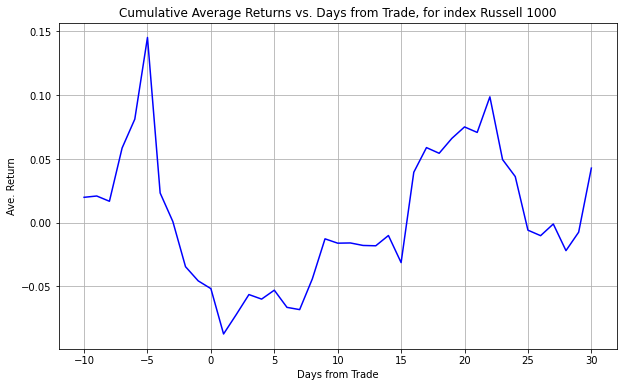

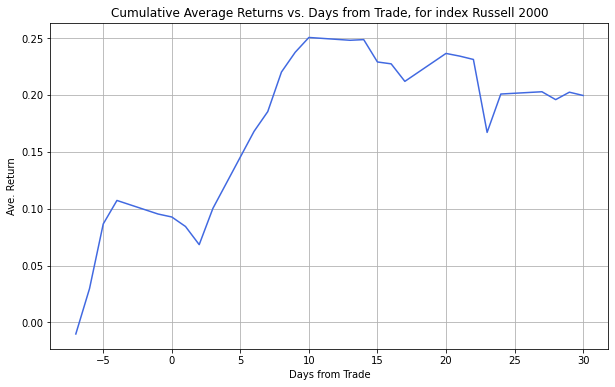

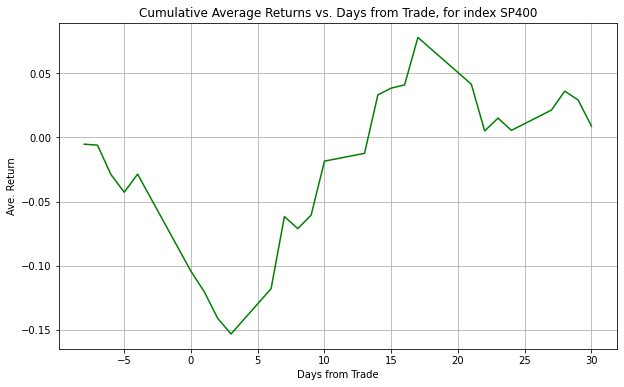

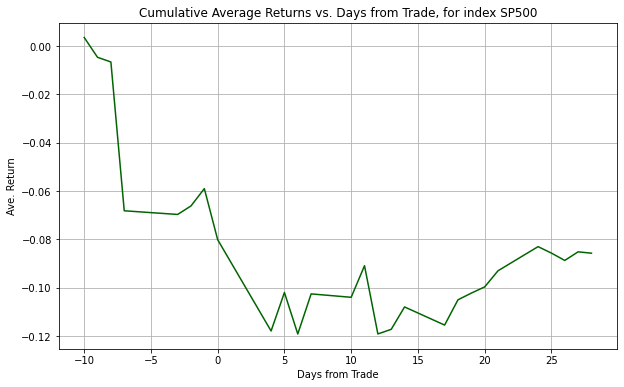

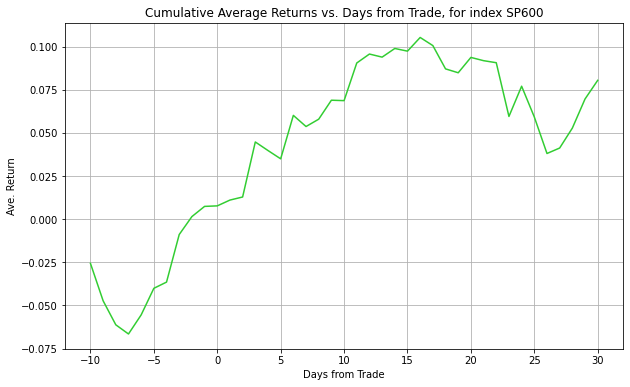

In [99]:
# Plot the Average return, grouped by Index
average_returns_downweight_only = data_downweight_only.groupby(['Index', 'Days from Trade'])['Normalized Return'].mean().reset_index()
indices_downweight = sorted(data_downweight_only['Index'].unique())

# Plot the average returns
for index in indices_downweight:
    plt.figure(figsize=(10, 6))
    subset = average_returns_downweight_only[average_returns_downweight_only['Index'] == index]
    subset = subset[(subset['Days from Trade'] < 31) & (subset['Days from Trade'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Index')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Trade'], subset['Cumulative Average Return'], alpha=1, label=index, color=index_colors[index])
    plt.title('Cumulative Average Returns vs. Days from Trade, for index ' + index)
    plt.xlabel('Days from Trade')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

Similar to the conclusion of previous graphs, the graphs mapping against "Days from Trade" does not depart from the previous graphs significantly.

Due to the lack of observations, I prefer not to take a position around the "Downweight" events

We now move onto the Reclassification Events

## 5 Return Behaviors around the Reclassification Events

It should be noted first that reclassificaiton events, such as "SP500 to SP600" are often featured under both indices. Further, e.g. "SP500 to SP600" presumably would have very different dynamics to "SP600 to SP500". Therefore, instead of grouping by indices, here we would group by actions. 

Intuition would suggest that since SP500 index funds have a larger following, reclassifying to SP500 may lead to price increase. On the other hand, reclassification to a larger cap may suggest that the company is growing, so the causal direction is not clear.

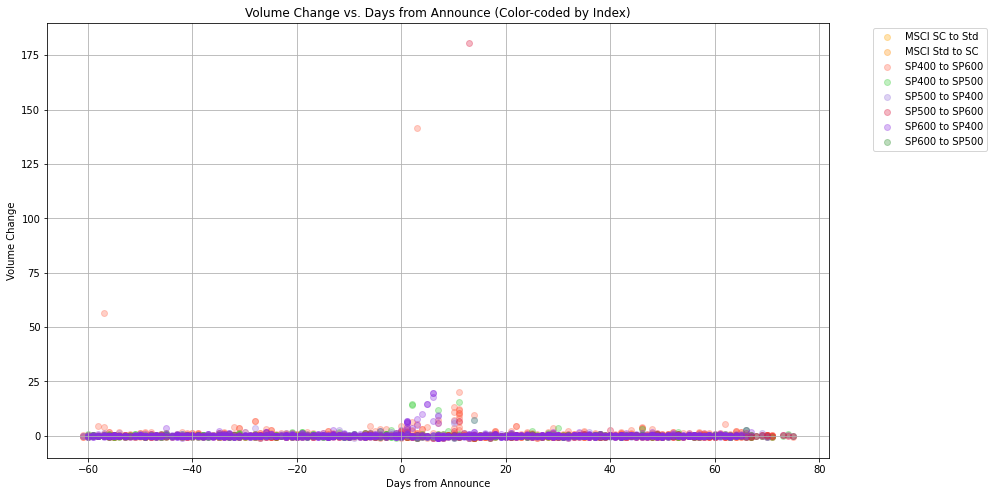

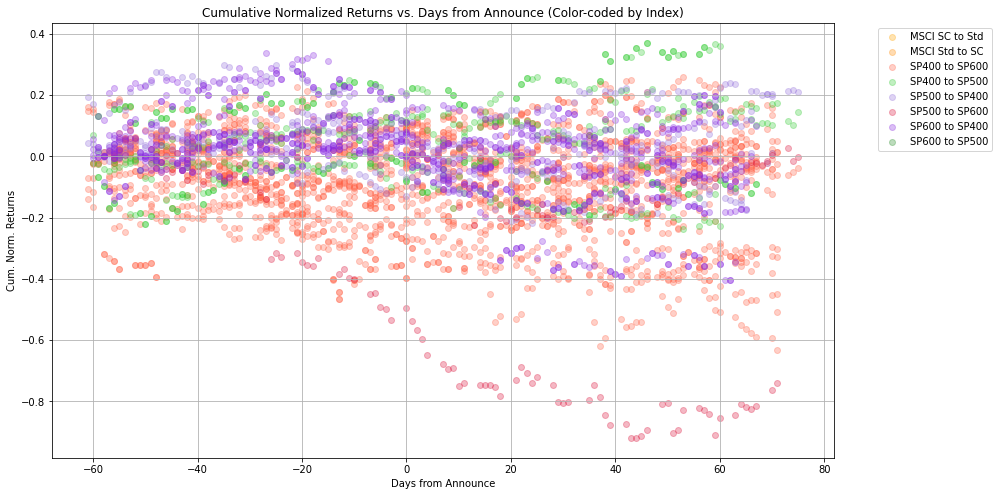

In [116]:
# Filter for actions that indicate index changes
reclassify_action_patterns = price_data['Action'].str.contains(' to ', case=False, na=False)
filtered_price_data_df = price_data.loc[reclassify_action_patterns]

# Drop duplicates based on 'Date', 'Ticker', 'Action', and 'Close' columns
reclassify_data_df = filtered_price_data_df.drop_duplicates(subset=['Date', 'Ticker', 'Action', 'Close'])

# # Display the resulting dataframe
# reclassify_data_df.head(), reclassify_data_df.shape

# Reset index to plot
reclassify_data_df = reclassify_data_df.reset_index(drop=True)

# Define the action colors
action_colors = {
    'MSCI SC to Std': '#FFA500',  # Orange
    'MSCI Std to SC': '#FF8C00',  # Dark Orange
    'SP400 to SP600': '#FF6347',  # Tomato (red shade)
    'SP400 to SP500': '#32CD32',  # Lime Green
    'SP500 to SP400': '#9370DB',  # Medium Purple
    'SP500 to SP600': '#DC143C',  # Crimson (red shade)
    'SP600 to SP400': '#8A2BE2',  # Blue Violet (purple shade)
    'SP600 to SP500': '#228B22',  # Forest Green
}

# Plot the volume, color-coded by indices
plt.figure(figsize=(14, 8))
for action, color in action_colors.items():
    subset = reclassify_data_df[reclassify_data_df['Action'] == action]
    plt.scatter(subset['Days from Announce'], subset['Volume Change'], alpha=0.3, label=action, color=color)

plt.title('Volume Change vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Volume Change')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot normalized returns for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))
for action, color in action_colors.items():
    subset = reclassify_data_df[reclassify_data_df['Action'] == action]
    plt.scatter(subset['Days from Announce'], subset['Cumulative Normalized Return'], alpha=0.3, label=action, color=color)

plt.title('Cumulative Normalized Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Cum. Norm. Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

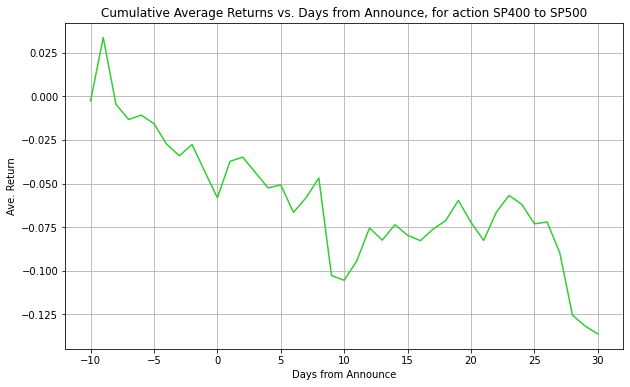

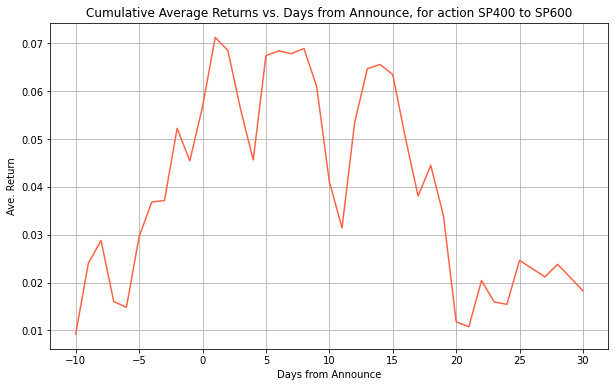

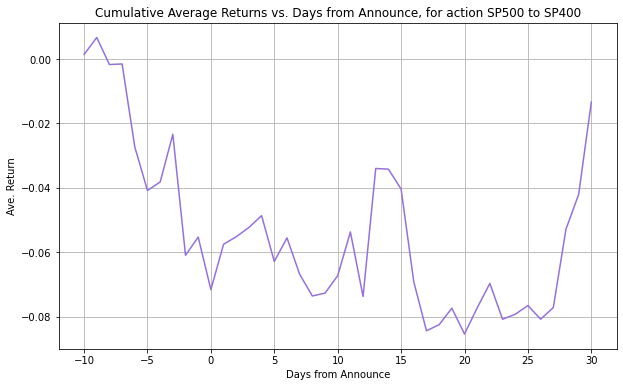

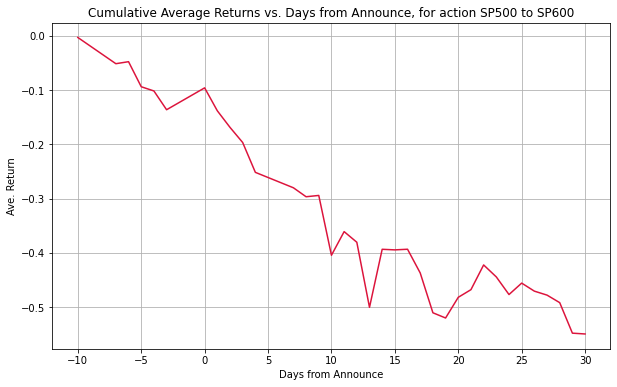

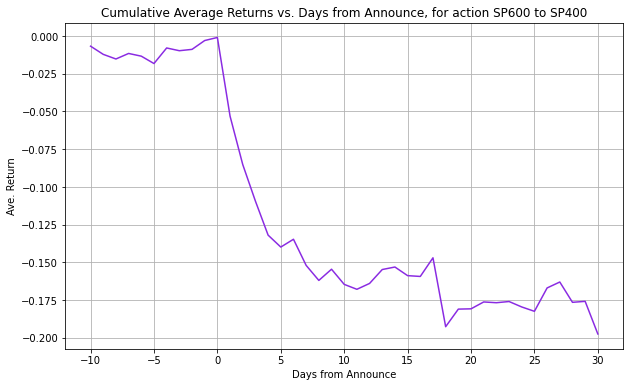

In [117]:
# Plot the Average return, grouped by Action
average_returns_reclassify = reclassify_data_df.groupby(['Action', 'Days from Announce'])['Normalized Return'].mean().reset_index()
actions_reclassify = sorted(reclassify_data_df['Action'].unique())

# Plot the average returns
for action in actions_reclassify:
    plt.figure(figsize=(10, 6))
    subset = average_returns_reclassify[average_returns_reclassify['Action'] == action]
    subset = subset[(subset['Days from Announce'] < 31) & (subset['Days from Announce'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Action')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Announce'], subset['Cumulative Average Return'], alpha=1, label=action, color=action_colors.get(action, '#000000'))  # Default to black if action color is not defined
    plt.title('Cumulative Average Returns vs. Days from Announce, for action ' + action)
    plt.xlabel('Days from Announce')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

It seems that in general, all cross-index reclassifications for the SP series led to a decrease in returns, for the next 10 days.

Below we present the graphs against "Days from Trade":

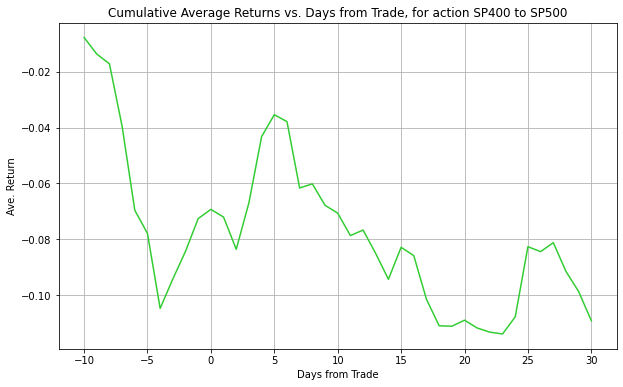

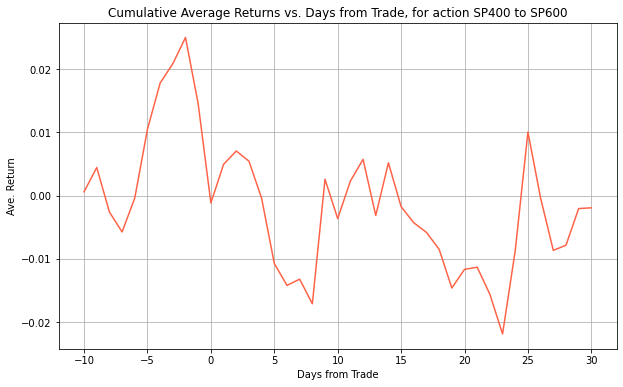

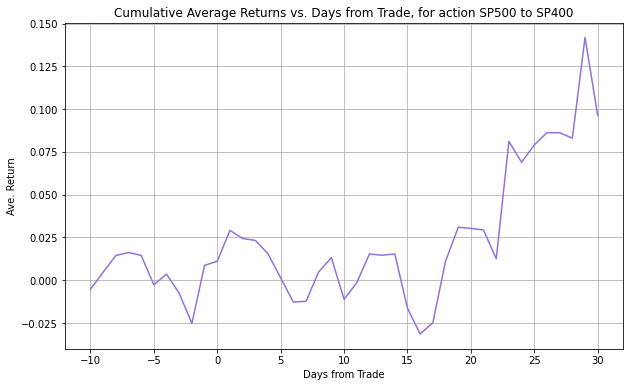

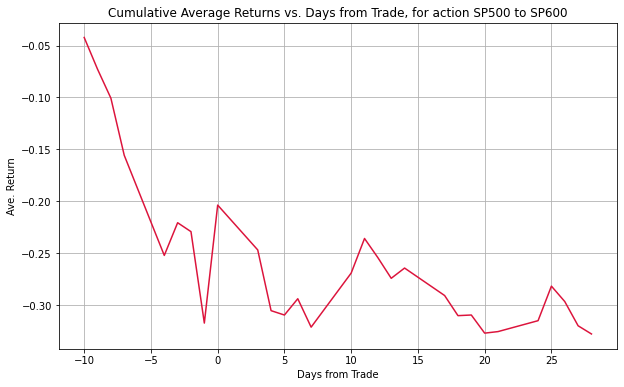

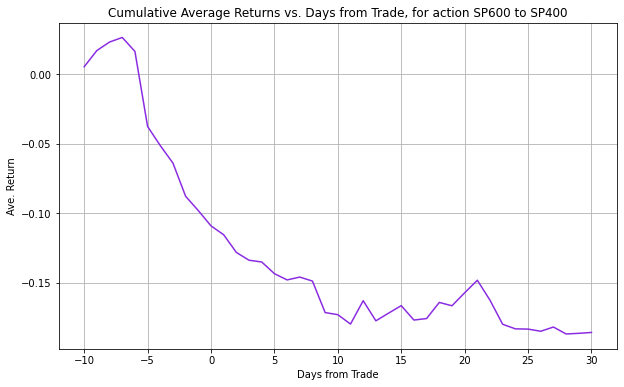

In [118]:
# Plot the Average return, grouped by Action
average_returns_reclassify = reclassify_data_df.groupby(['Action', 'Days from Trade'])['Normalized Return'].mean().reset_index()
actions_reclassify = sorted(reclassify_data_df['Action'].unique())

# Plot the average returns
for action in actions_reclassify:
    plt.figure(figsize=(10, 6))
    subset = average_returns_reclassify[average_returns_reclassify['Action'] == action]
    subset = subset[(subset['Days from Trade'] < 31) & (subset['Days from Trade'] > -11)]
    subset['Cumulative Average Return'] = subset.groupby('Action')['Normalized Return'].cumsum()
    plt.plot(subset['Days from Trade'], subset['Cumulative Average Return'], alpha=1, label=action, color=action_colors.get(action, '#000000'))  # Default to black if action color is not defined
    plt.title('Cumulative Average Returns vs. Days from Trade, for action ' + action)
    plt.xlabel('Days from Trade')
    plt.ylabel('Ave. Return')
    plt.grid(True)
plt.show()

We still see largely similar patterns. Notably, "SP400 to SP500" features a jump followed by a drop when mapped against trading, suggesting major funds reposition events.

So our tentative trading strategy is to short after all reclassification event annoucements, and close the positions after 10 days.

This concludes our analysis of the return behaviors around news anouncements. The next file would be for backtesting.